In [1]:
import pandas as pd
import numpy as np
import sys
import os
sys.path.append(os.path.join(os.getcwd(),"..","..","Algorithm encapsulation"))
from SimAnalysis import SimAnalysis
from LMband import LMband
from Multiband import Multiband
from MXband import MXband
from MPbandTool import MPbandTool
from MPband import MPband


In [2]:
def get_rf(d,p):
    tmp=[]
    for i,a in enumerate(p):
        idx=np.where(a!=0)[0]
        a=a&0
        if len(idx)>0:
            a[:idx[0]]=1
        tmp.append((d[i]*a).sum())
    return tmp

In [3]:

def left_clear(q1,q2,onr,inr):
    gamma=np.zeros((2,len(q1)))
    for i in range(len(q1)):
        gamma[0,i]=q1[i]/1650/onr[i-1]
        gamma[1,i]=q2[i]/1650/inr[i-1]
    return gamma

In [4]:
phase = np.loadtxt("../data/phase")
cir=phase[0].sum()
phase=phase/cir
vol = np.loadtxt("../data/volume")
qv = np.loadtxt("../data/path_vol")
phase_get = np.load("../data/phase_get.npy")
d = np.loadtxt("../data/distance")
straight_get = np.load("../data/straight_get.npy")
ison = np.array([0, 0, 0, 1, 1, 1])
q_on=np.array([0,394,186,382,647,120,0,443,116,621,65,591,88])
q_in=np.array([0,459,362,604,69,0,103,573,190,375,118,154,225])
n_road_on=[2,2,2,2,3,3,3,3,3,3,3,3,3]
n_road_in=[2,2,2,2,3,2,3,3,3,3,2,2,3]

# px = left_clear(q_on,q_in,n_road_on,n_road_in)
px = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
pxb = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
qb=[120,120]
lower, upper = 8, 14
linspace = np.arange(lower, upper, 1)
lin_num = len(linspace)

# 南北直行方向绿灯时间
sg=np.array([(straight_get[i]*phase).sum(axis=1) for i in range(len(straight_get))])
rho = vol[0] / vol[1]
num = len(vol[0])
numr = len(qv)
nump = len(phase_get)
M = 1e6
nx = 0.00000001
be = 8
speedScope = np.array([lower, upper])
speedVar = np.array([-2, 2])

g=np.array([(phase_get[i]*phase).sum(axis=1) for i in range(numr) ])
r=1-g
rf=np.array([get_rf(phase,phase_get[i]) for i in range(numr)])

ex=[1,0,1,0,1,0,1,1,1,1,1,0]
dwt=15
qb_x=np.ones_like(sg)*20
cap=np.ones_like(sg,dtype=int)*3

spd_on=pd.read_csv(os.path.join(os.getcwd(),"..","..","speed analysis","上行速度数据.csv"),index_col=0)
spd_in=pd.read_csv(os.path.join(os.getcwd(),"..","..","speed analysis","下行速度数据.csv"),index_col=0)
p=[0,0,0,0,1,0,0,0,1,0,1,0,0]



In [5]:
def sim_start(df,name,sta):
    sim=SimAnalysis(df,phase,ex,os.path.join(os.getcwd(),"..","..","vissim","aa","zhongsan.inp"),
                os.path.join(os.getcwd(),"..","..","vissim","aa","vissim.ini"),
                os.path.join(os.getcwd(),"..","..","vissim","aa","zhongsan - 副本.inp"))
    sim.set_saturation(sta)
    sim.start()
    spdx=sim.analysis_speed(os.path.join(os.getcwd(),"..","..","vissim","aa",'zhongsan - 副本.fzp'))
    delayx=sim.analysis_delay(os.path.join(os.getcwd(),"..","..","vissim","aa",'zhongsan - 副本.vlz'))
    tvltx=sim.analysis_traveltime(os.path.join(os.getcwd(),"..","..","vissim","aa",'zhongsan - 副本.rsz'))
    spdx.to_csv("./staturation/speed_{}.csv".format(name),encoding="utf-8-sig")
    delayx.to_csv("./staturation/delay_{}.csv".format(name),encoding="utf-8-sig")
    tvltx.to_csv("./staturation/traveltime_{}.csv".format(name),encoding="utf-8-sig")

In [6]:
def LMband_sensitivity(cycle,sta,dwt,tpy,idx):
    lmb=LMband(phase, [cycle[0],cycle[1]], vol*sta, qv*sta, phase_get, d, straight_get, ison, px, pxb, qb,qb_x,cap, lower, upper, 
           linspace, be, speedVar[0], speedVar[1],ex, dwt,lower,upper,speedVar[0], speedVar[1],spd_on,spd_in)
    lmb.set_M2_time_limit(60*15)
    lmb.solve()
    df=lmb.get_dataframe()
    sim_start(df,"{}_{}_{}".format("LMB",tpy,idx),sta)

In [7]:
def Multiband_sensitivity(cycle,sta,dwt,tpy,idx):
    mb=Multiband(phase,[cycle[0],cycle[1]],straight_get,p,d,lower,upper,speedVar[0], speedVar[1],vol,px)
    mb._solve()
    a=mb.get_dataframe()
    mpb=MPbandTool(phase, [cycle[0],cycle[1]], vol*sta, qv*sta, phase_get, d, straight_get, ison, px, pxb, qb, lower, upper, 
            be, speedVar[0], speedVar[1],ex, dwt,lower,upper,speedVar[0], speedVar[1],p,a.offset/a.z,
            1/a.z,np.array([a.t1/a.z,a.t2/a.z]))
    mpb._solve()
    df=mpb.get_dataframe()
    df["dw1"]=np.ones_like(df.z)*dwt
    df["dw2"]=np.ones_like(df.z)*dwt
    sim_start(df,"{}_{}_{}".format("MB",tpy,idx),sta)
    

In [8]:
def MXband_sensitivity(cycle,sta,dwt,tpy,idx):
    mb=MXband(phase,[cycle[0],cycle[1]],straight_get,d,lower,upper,speedVar[0], speedVar[1],vol,px)
    mb._solve()
    a=mb.get_dataframe()
    mpb=MPbandTool(phase, [80,180], vol*sta, qv*sta, phase_get, d, straight_get, ison, px, pxb, qb, lower, upper, 
                be, speedVar[0], speedVar[1],ex, dwt,lower,upper,speedVar[0], speedVar[1],a.p,a.offset/a.z,
                1/a.z,np.array([a.t1/a.z,a.t2/a.z]))
    mpb._solve()
    df=mpb.get_dataframe()
    df["dw1"]=np.ones_like(df.z)*dwt
    df["dw2"]=np.ones_like(df.z)*dwt
    sim_start(df,"{}_{}_{}".format("MXB",tpy,idx),sta)

In [9]:
def MPband_sensitivity(cycle,sta,dwt,tpy,idx):
    mpb=MPband(phase, [cycle[0],cycle[1]], vol*sta, qv*sta, phase_get, d, straight_get, ison, px, pxb, qb, lower, upper, 
            be, speedVar[0], speedVar[1],ex, dwt,lower,upper,speedVar[0], speedVar[1],p)
    mpb._solve()
    df=mpb.get_dataframe()
    sim_start(df,"{}_{}_{}".format("MPB",tpy,idx),sta)

In [10]:
cycle_list=np.array([80, 100, 120, 140,160, 180])
dwt_list=np.array([10, 12, 14, 16, 18, 20])
sta_list=[0.4,0.6,0.8, 1, 1.2, 1.4,1.6]

In [26]:
def cycle_analysis():
    #周期灵敏度分析
    for i in cycle_list:
        LMband_sensitivity([i,i],1,15,"cycle",i)
        Multiband_sensitivity([i,i],1,15,"cycle",i)
        MXband_sensitivity([i,i],1,15,"cycle",i)
        MPband_sensitivity([i,i],1,15,"cycle",i)
cycle_analysis()

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              201903125
Tried aggregator 2 times.
MIP Presolve eliminated 467 rows and 117 columns.
MIP Presolve modified 973 coefficients.
Aggregator did 52 substitutions.
Reduced MIP has 841 rows, 436 columns, and 2806 nonzeros.
Reduced MIP has 68 binaries, 76 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (3.13 ticks)
Probing fixed 0 vars, tightened 51 bounds.
Probing time = 0.00 sec. (0.32 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve modified 244 coefficients.
Reduced MIP has 841 rows, 436 columns, and 2806 nonzeros.
Reduced MIP has 68 binaries, 76 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.57 ticks)
Probing time = 0.02 sec. (0.30 ticks)
Clique table members: 29.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using 

In [12]:
def dwelltime_analysis():
    for i in [10, 12, 14, 16, 18, 20]:
        LMband_sensitivity([80,180],1,i,"dwt",i)
        Multiband_sensitivity([80,180],1,i,"dwt",i)
        MXband_sensitivity([80,180],1,i,"dwt",i)
        MPband_sensitivity([80,180],1,i,"dwt",i)
dwelltime_analysis()

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              201903125
Tried aggregator 2 times.
MIP Presolve eliminated 335 rows and 104 columns.
MIP Presolve modified 1043 coefficients.
Aggregator did 52 substitutions.
Reduced MIP has 973 rows, 449 columns, and 3188 nonzeros.
Reduced MIP has 68 binaries, 76 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (3.30 ticks)
Probing fixed 0 vars, tightened 51 bounds.
Probing time = 0.00 sec. (0.33 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve modified 244 coefficients.
Reduced MIP has 973 rows, 449 columns, and 3188 nonzeros.
Reduced MIP has 68 binaries, 76 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.73 ticks)
Probing time = 0.00 sec. (0.31 ticks)
Clique table members: 29.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using

In [13]:
def staturation_analysis():
    for i in [0.4,0.6,0.8, 1, 1.2, 1.4,1.6]:
        LMband_sensitivity([80,180],i,15,"sta",i)
        Multiband_sensitivity([80,180],i,15,"sta",i)
        MXband_sensitivity([80,180],i,15,"sta",i)
        MPband_sensitivity([80,180],i,15,"sta",i)
# staturation_analysis()

In [14]:
def get_path_delay(data):
    tmp=data[[colx for colx in data.columns if "delay" in colx and " " not in colx]].iloc[-1]
    return tmp[0],tmp[6:].mean()
    # return tmp
def get_path_traveltime(data):
    tmp=data[[colx for colx in data.columns if "traveltime" in colx and " " not in colx]]
    tmp=tmp[tmp!=0].mean()
    return (tmp["traveltime1"]+tmp["traveltime4"])/2,(tmp["traveltime7"]+tmp["traveltime8"])/2
    # return tmp

In [15]:
data=pd.read_csv("./staturation/delay_{}_{}_{}.csv".format("LMB","cycle",80))
tmp=get_path_delay(data)
tmp

(0.0, 0.0)

In [16]:
def get_delay(ls,tpy):
    res=dict()
    res["LMB"]=[[],[]]
    res["MB"]=[[],[]]
    res["MPB"]=[[],[]]
    res["MXB"]=[[],[]]
    for i in ls:
        data=pd.read_csv("./staturation/delay_{}_{}_{}.csv".format("LMB",tpy,i))
        tmp=get_path_delay(data)
        res["LMB"][0].append(tmp[0])
        res["LMB"][1].append(tmp[1])
        data=pd.read_csv("./staturation/delay_{}_{}_{}.csv".format("MB",tpy,i))
        tmp=get_path_delay(data)
        res["MB"][0].append(tmp[0])
        res["MB"][1].append(tmp[1])
        data=pd.read_csv("./staturation/delay_{}_{}_{}.csv".format("MPB",tpy,i))
        tmp=get_path_delay(data)
        res["MPB"][0].append(tmp[0])
        res["MPB"][1].append(tmp[1])
        data=pd.read_csv("./staturation/delay_{}_{}_{}.csv".format("MXB",tpy,i))
        tmp=get_path_delay(data)
        res["MXB"][0].append(tmp[0])
        res["MXB"][1].append(tmp[1])
    return res
def get_traveltime(ls,tpy):
    res=dict()
    res["LMB"]=[[],[]]
    res["MB"]=[[],[]]
    res["MPB"]=[[],[]]
    res["MXB"]=[[],[]]
    for i in ls:
        data=pd.read_csv("./staturation/traveltime_{}_{}_{}.csv".format("LMB",tpy,i))
        tmp=get_path_traveltime(data)
        res["LMB"][0].append(tmp[0])
        res["LMB"][1].append(tmp[1])
        data=pd.read_csv("./staturation/traveltime_{}_{}_{}.csv".format("MB",tpy,i))
        tmp=get_path_traveltime(data)
        res["MB"][0].append(tmp[0])
        res["MB"][1].append(tmp[1])
        data=pd.read_csv("./staturation/traveltime_{}_{}_{}.csv".format("MPB",tpy,i))
        tmp=get_path_traveltime(data)
        res["MPB"][0].append(tmp[0])
        res["MPB"][1].append(tmp[1])
        data=pd.read_csv("./staturation/traveltime_{}_{}_{}.csv".format("MXB",tpy,i))
        tmp=get_path_traveltime(data)
        res["MXB"][0].append(tmp[0])
        res["MXB"][1].append(tmp[1])
    return res

In [27]:
dc=get_delay(cycle_list,"cycle")
dt=get_traveltime(cycle_list,"cycle")

In [18]:
import seaborn as sns 
import matplotlib.patches as pch 
import matplotlib.pyplot as plt

In [19]:
# fig2 = plt.figure(figsize=[8, 6], dpi=300)
# plt.plot(cycle_list,dc["MB"][0],label='Multiband',linestyle="-",linewidth=1.5, marker='.',markersize=10,color='Grey',markerfacecolor='Grey')
# plt.plot(cycle_list,dc["MXB"][0],label='MTband',linestyle="-.",linewidth=1.5, marker='^',markersize=10,color='Grey',markerfacecolor='Grey')
# plt.plot(cycle_list,dc["MPB"][0],label='MPband',linestyle="--",linewidth=1.5, marker='8',markersize=10,color='Grey',markerfacecolor='Grey')
# plt.plot(cycle_list,dc["LMB"][0],label='MTPband',linestyle=":",linewidth=1.5, marker='X',markersize=10,color='Grey',markerfacecolor='Grey')
# plt.legend(fontsize=16,loc="upper left")
# # plt.xticks([i+1 for i in range(13)])
# # plt.ylim([50,170])
# plt.xlabel('cross', fontsize=18)
# plt.ylabel('Delay', fontsize=18)
# plt.tick_params(labelsize=16)
# # plt.title("延误随饱和度的变化趋势", fontsize=16, y=-.11)
# fig2.savefig('./spx15',bbox_inches="tight")

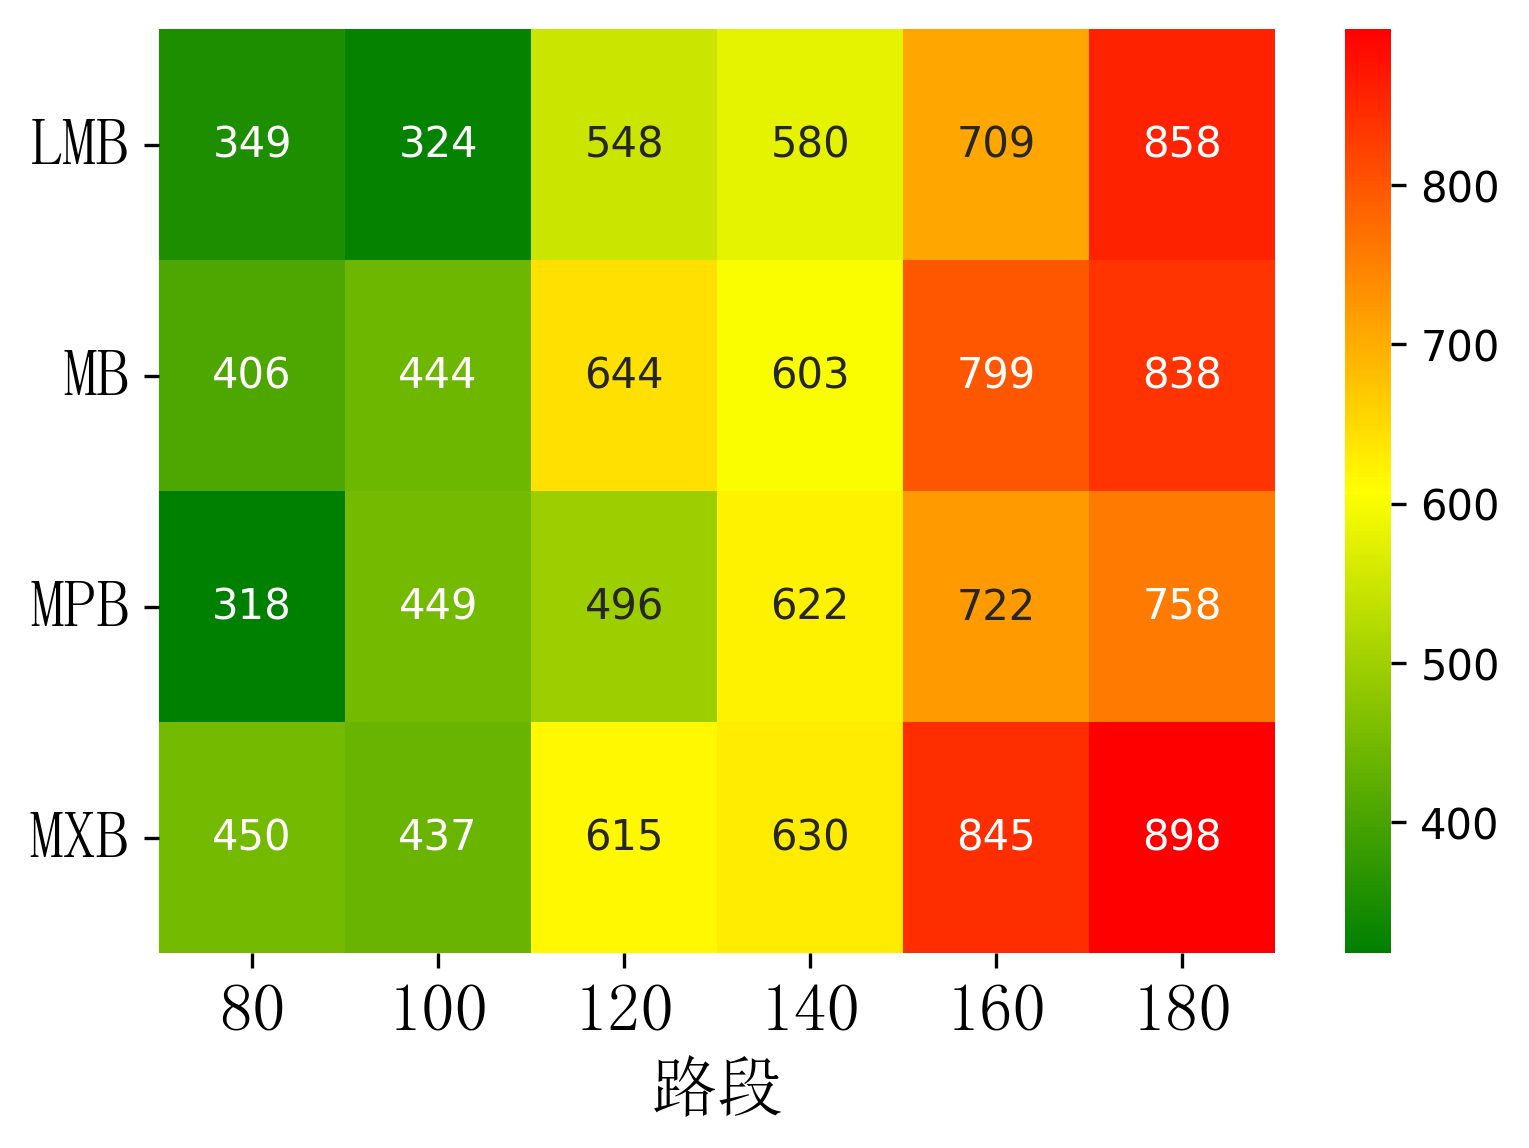

In [28]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import palettable#python颜色库
# from sklearn import datasets 
dc1=[dc[k][0] for k in dc.keys()]
font1 = {'family': 'SimSun', 'size':16, 'weight': 'normal'}
fig,ax=plt.subplots(dpi=300, figsize=(6,4))
sns.heatmap(dc1,cmap=LinearSegmentedColormap.from_list("", ["green", "yellow","red"]),annot=True,fmt=".0f")
# sns.heatmap(dh2[::-1].loc[:,:11],cmap=["green","yellow","red"],annot=True,fmt=".0f")
ax.set_xticklabels(cycle_list,fontdict=font1)
ax.set_yticklabels(dc.keys(), rotation=0,fontdict=font1)
ax.set_xlabel('路段',font1)
# ax.set_ylabel('速度/(km/h)',font1)
plt.show()
fig.tight_layout()#调整整体空白
# fig.savefig( "F:\\workspace\\jupyter\\论文\\graduation thesis\\pictures\\下行方向热力图",bbox_inches='tight')

In [21]:
# import seaborn as sns
# from matplotlib.colors import LinearSegmentedColormap
# import palettable#python颜色库
# # from sklearn import datasets 
# dc=get_delay(dwt_list,"dwt")
# dt=get_traveltime(dwt_list,"dwt")
# dc1=[dc[k][0] for k in dc.keys()]
# font1 = {'family': 'SimSun', 'size':16, 'weight': 'normal'}
# fig,ax=plt.subplots(dpi=300, figsize=(6,4))
# sns.heatmap(dc1,cmap=LinearSegmentedColormap.from_list("", ["green", "yellow","red"]),annot=True,fmt=".0f")
# # sns.heatmap(dh2[::-1].loc[:,:11],cmap=["green","yellow","red"],annot=True,fmt=".0f")
# ax.set_xticklabels(cycle_list,fontdict=font1)
# ax.set_yticklabels(dc.keys(), rotation=0,fontdict=font1)
# ax.set_xlabel('路段',font1)
# # ax.set_ylabel('速度/(km/h)',font1)
# plt.show()
# fig.tight_layout()#调整整体空白
# # fig.savefig( "F:\\workspace\\jupyter\\论文\\graduation thesis\\pictures\\下行方向热力图",bbox_inches='tight')

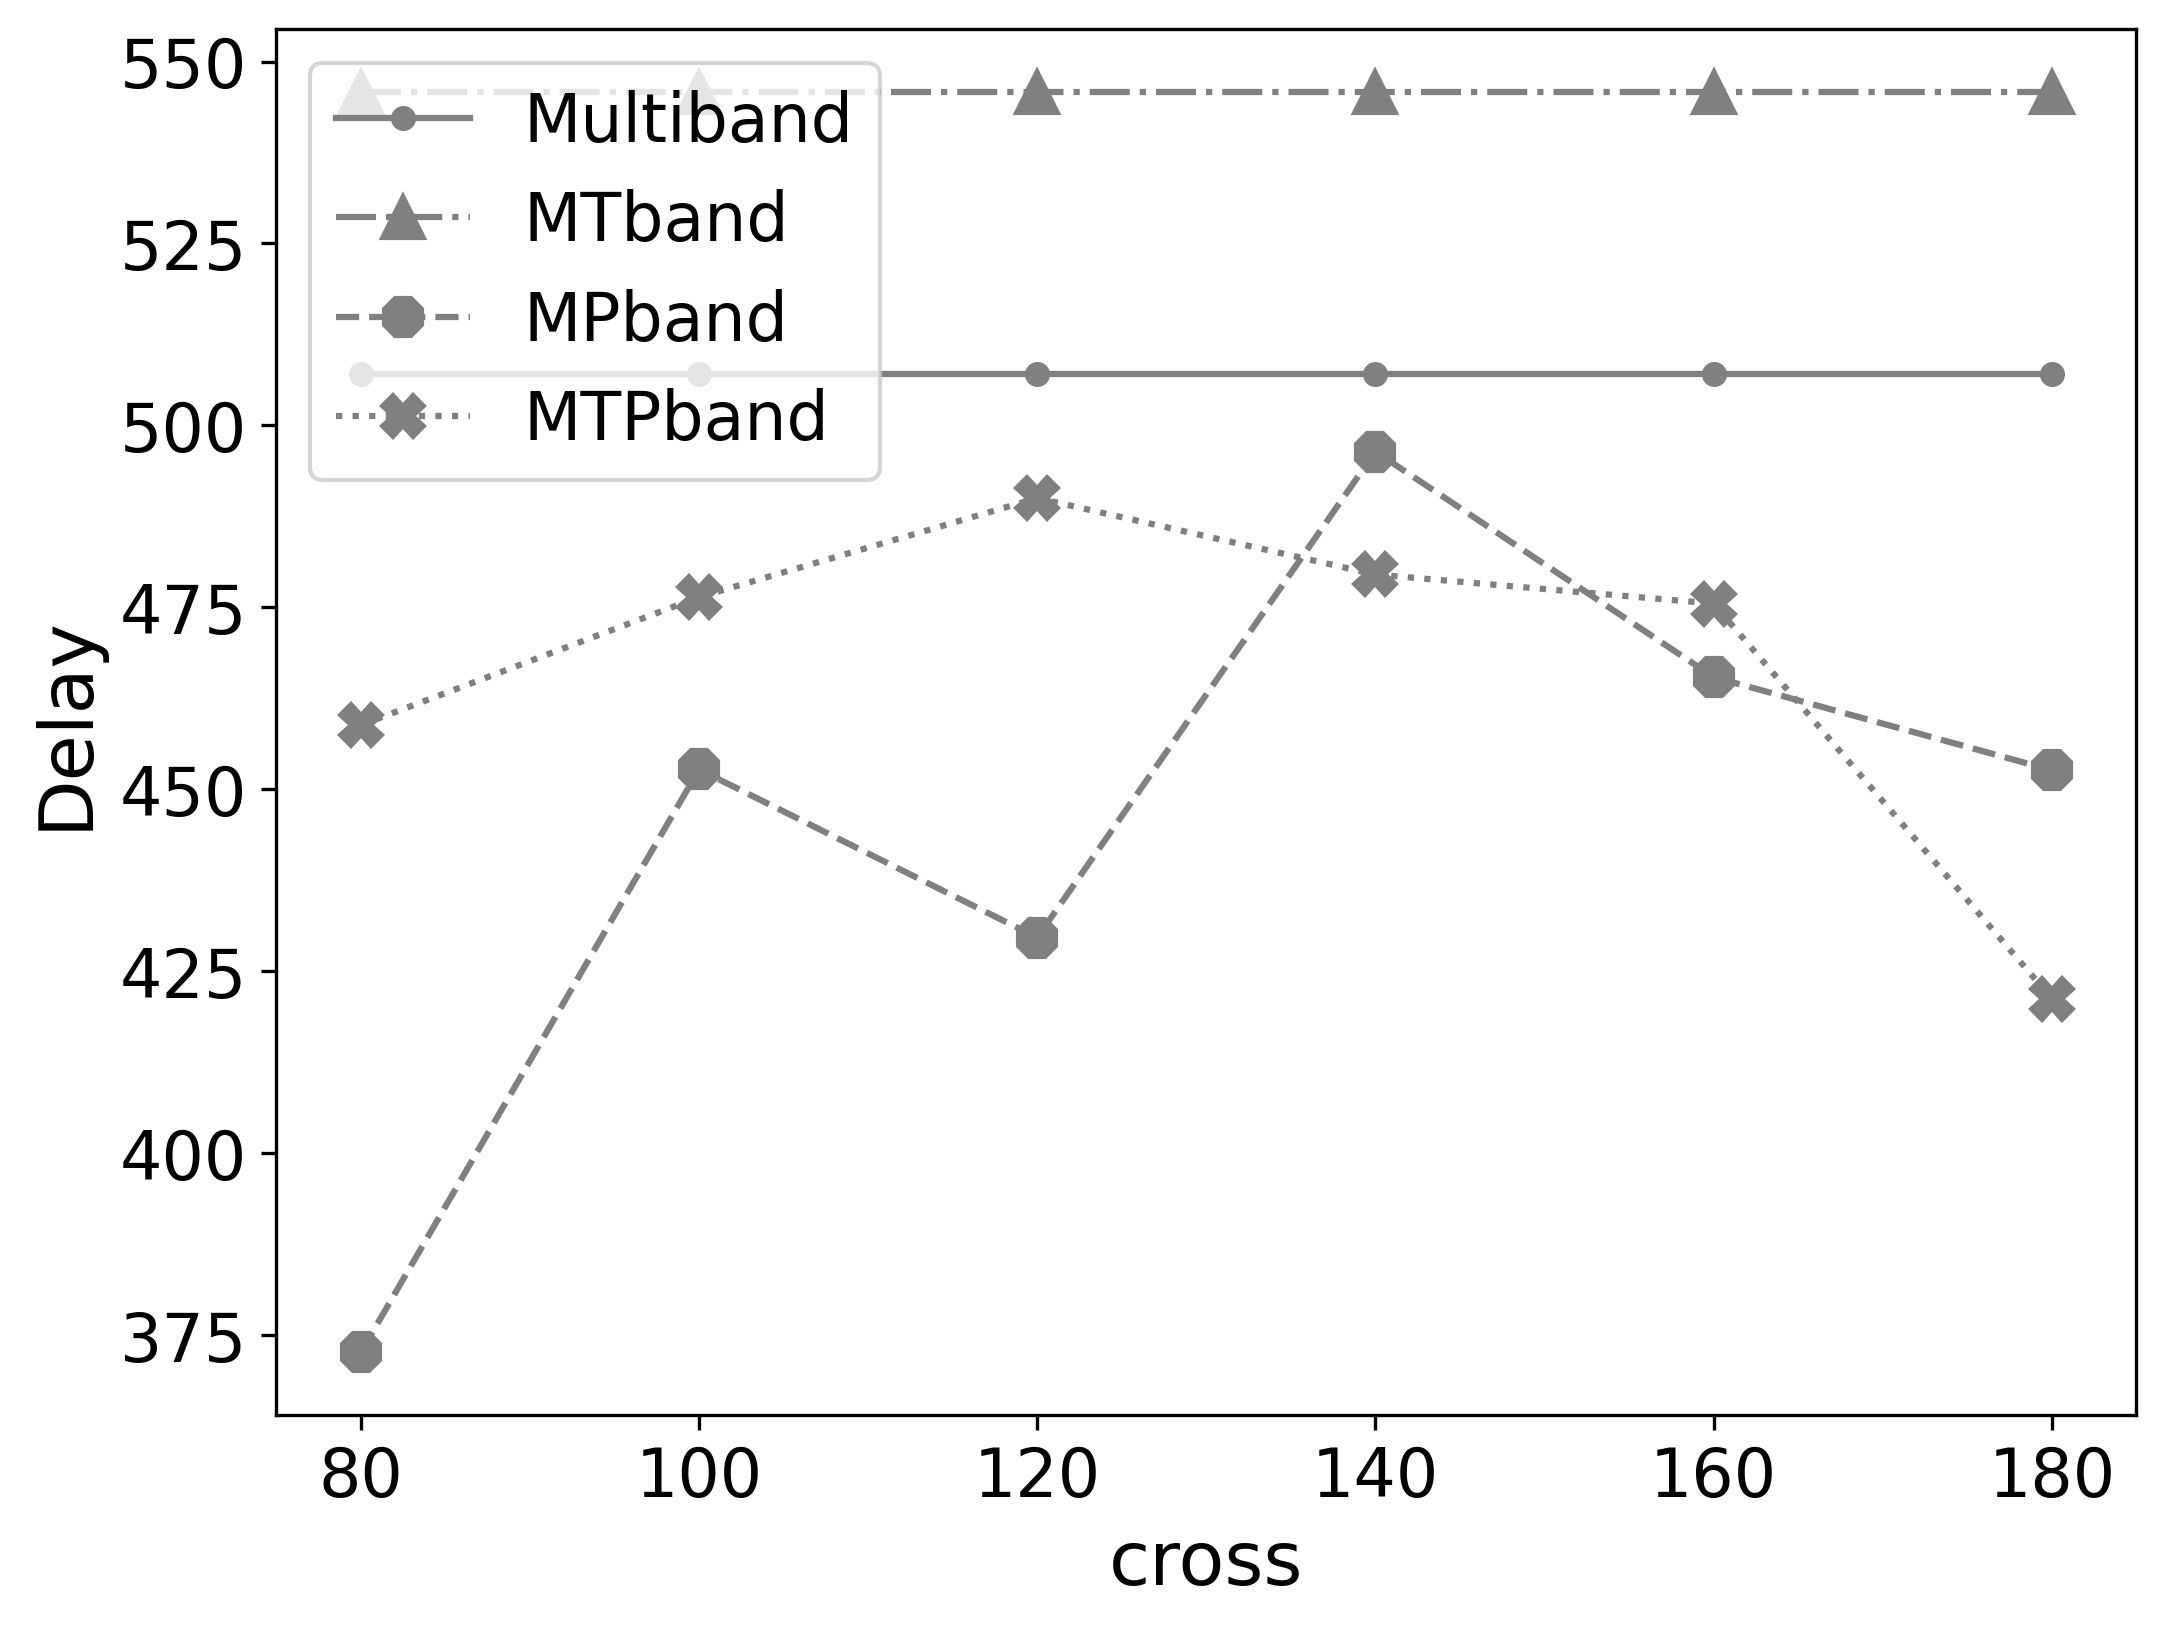

In [22]:
dc=get_delay(dwt_list,"dwt")
dt=get_traveltime(dwt_list,"dwt")

fig2 = plt.figure(figsize=[8, 6], dpi=300)
plt.plot(cycle_list,dc["MB"][0],label='Multiband',linestyle="-",linewidth=1.5, marker='.',markersize=10,color='Grey',markerfacecolor='Grey')
plt.plot(cycle_list,dc["MXB"][0],label='MTband',linestyle="-.",linewidth=1.5, marker='^',markersize=10,color='Grey',markerfacecolor='Grey')
plt.plot(cycle_list,dc["MPB"][0],label='MPband',linestyle="--",linewidth=1.5, marker='8',markersize=10,color='Grey',markerfacecolor='Grey')
plt.plot(cycle_list,dc["LMB"][0],label='MTPband',linestyle=":",linewidth=1.5, marker='X',markersize=10,color='Grey',markerfacecolor='Grey')
plt.legend(fontsize=16,loc="upper left")
# plt.xticks([i+1 for i in range(13)])
# plt.ylim([50,170])
plt.xlabel('cross', fontsize=18)
plt.ylabel('Delay', fontsize=18)
plt.tick_params(labelsize=16)
# plt.title("延误随饱和度的变化趋势", fontsize=16, y=-.11)
fig2.savefig('./spx15',bbox_inches="tight")

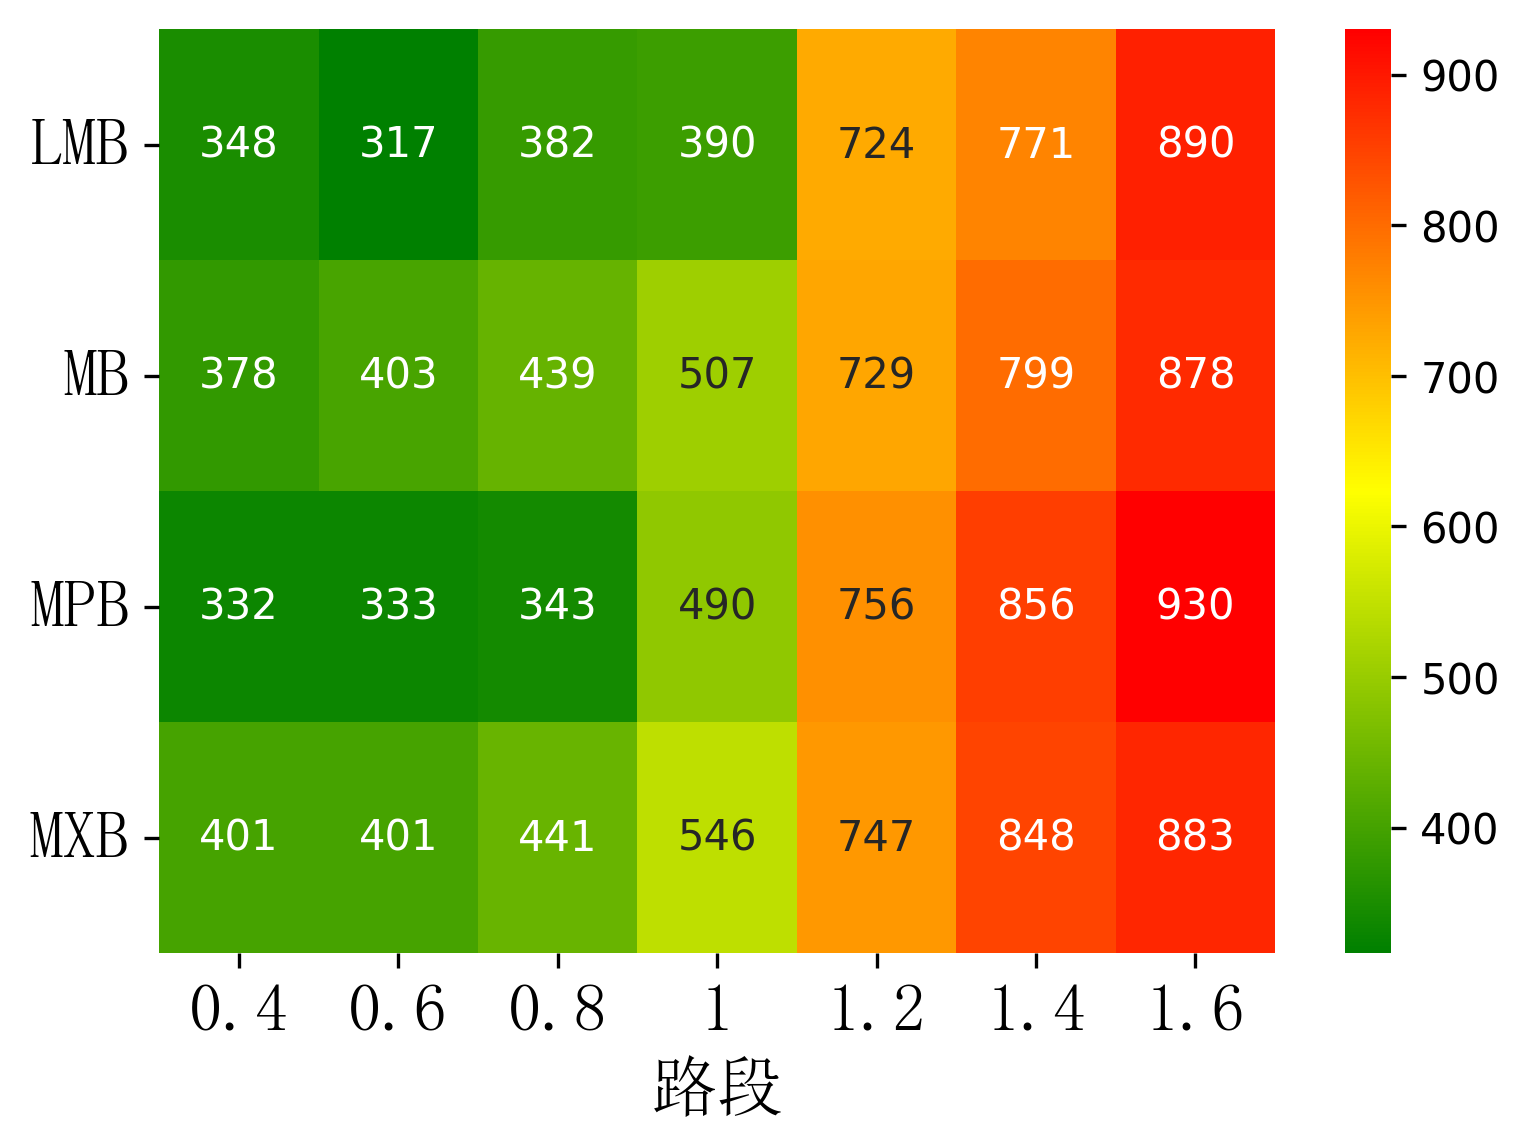

In [23]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import palettable#python颜色库
# from sklearn import datasets 
dc=get_delay(sta_list,"sta")
dt=get_traveltime(sta_list,"sta")
dc1=[dc[k][0] for k in dc.keys()]
font1 = {'family': 'SimSun', 'size':16, 'weight': 'normal'}
fig,ax=plt.subplots(dpi=300, figsize=(6,4))
sns.heatmap(dc1,cmap=LinearSegmentedColormap.from_list("", ["green", "yellow","red"]),annot=True,fmt=".0f")
# sns.heatmap(dh2[::-1].loc[:,:11],cmap=["green","yellow","red"],annot=True,fmt=".0f")
ax.set_xticklabels(sta_list,fontdict=font1)
ax.set_yticklabels(dc.keys(), rotation=0,fontdict=font1)
ax.set_xlabel('路段',font1)
# ax.set_ylabel('速度/(km/h)',font1)
plt.show()
fig.tight_layout()#调整整体空白
# fig.savefig( "F:\\workspace\\jupyter\\论文\\graduation thesis\\pictures\\下行方向热力图",bbox_inches='tight')

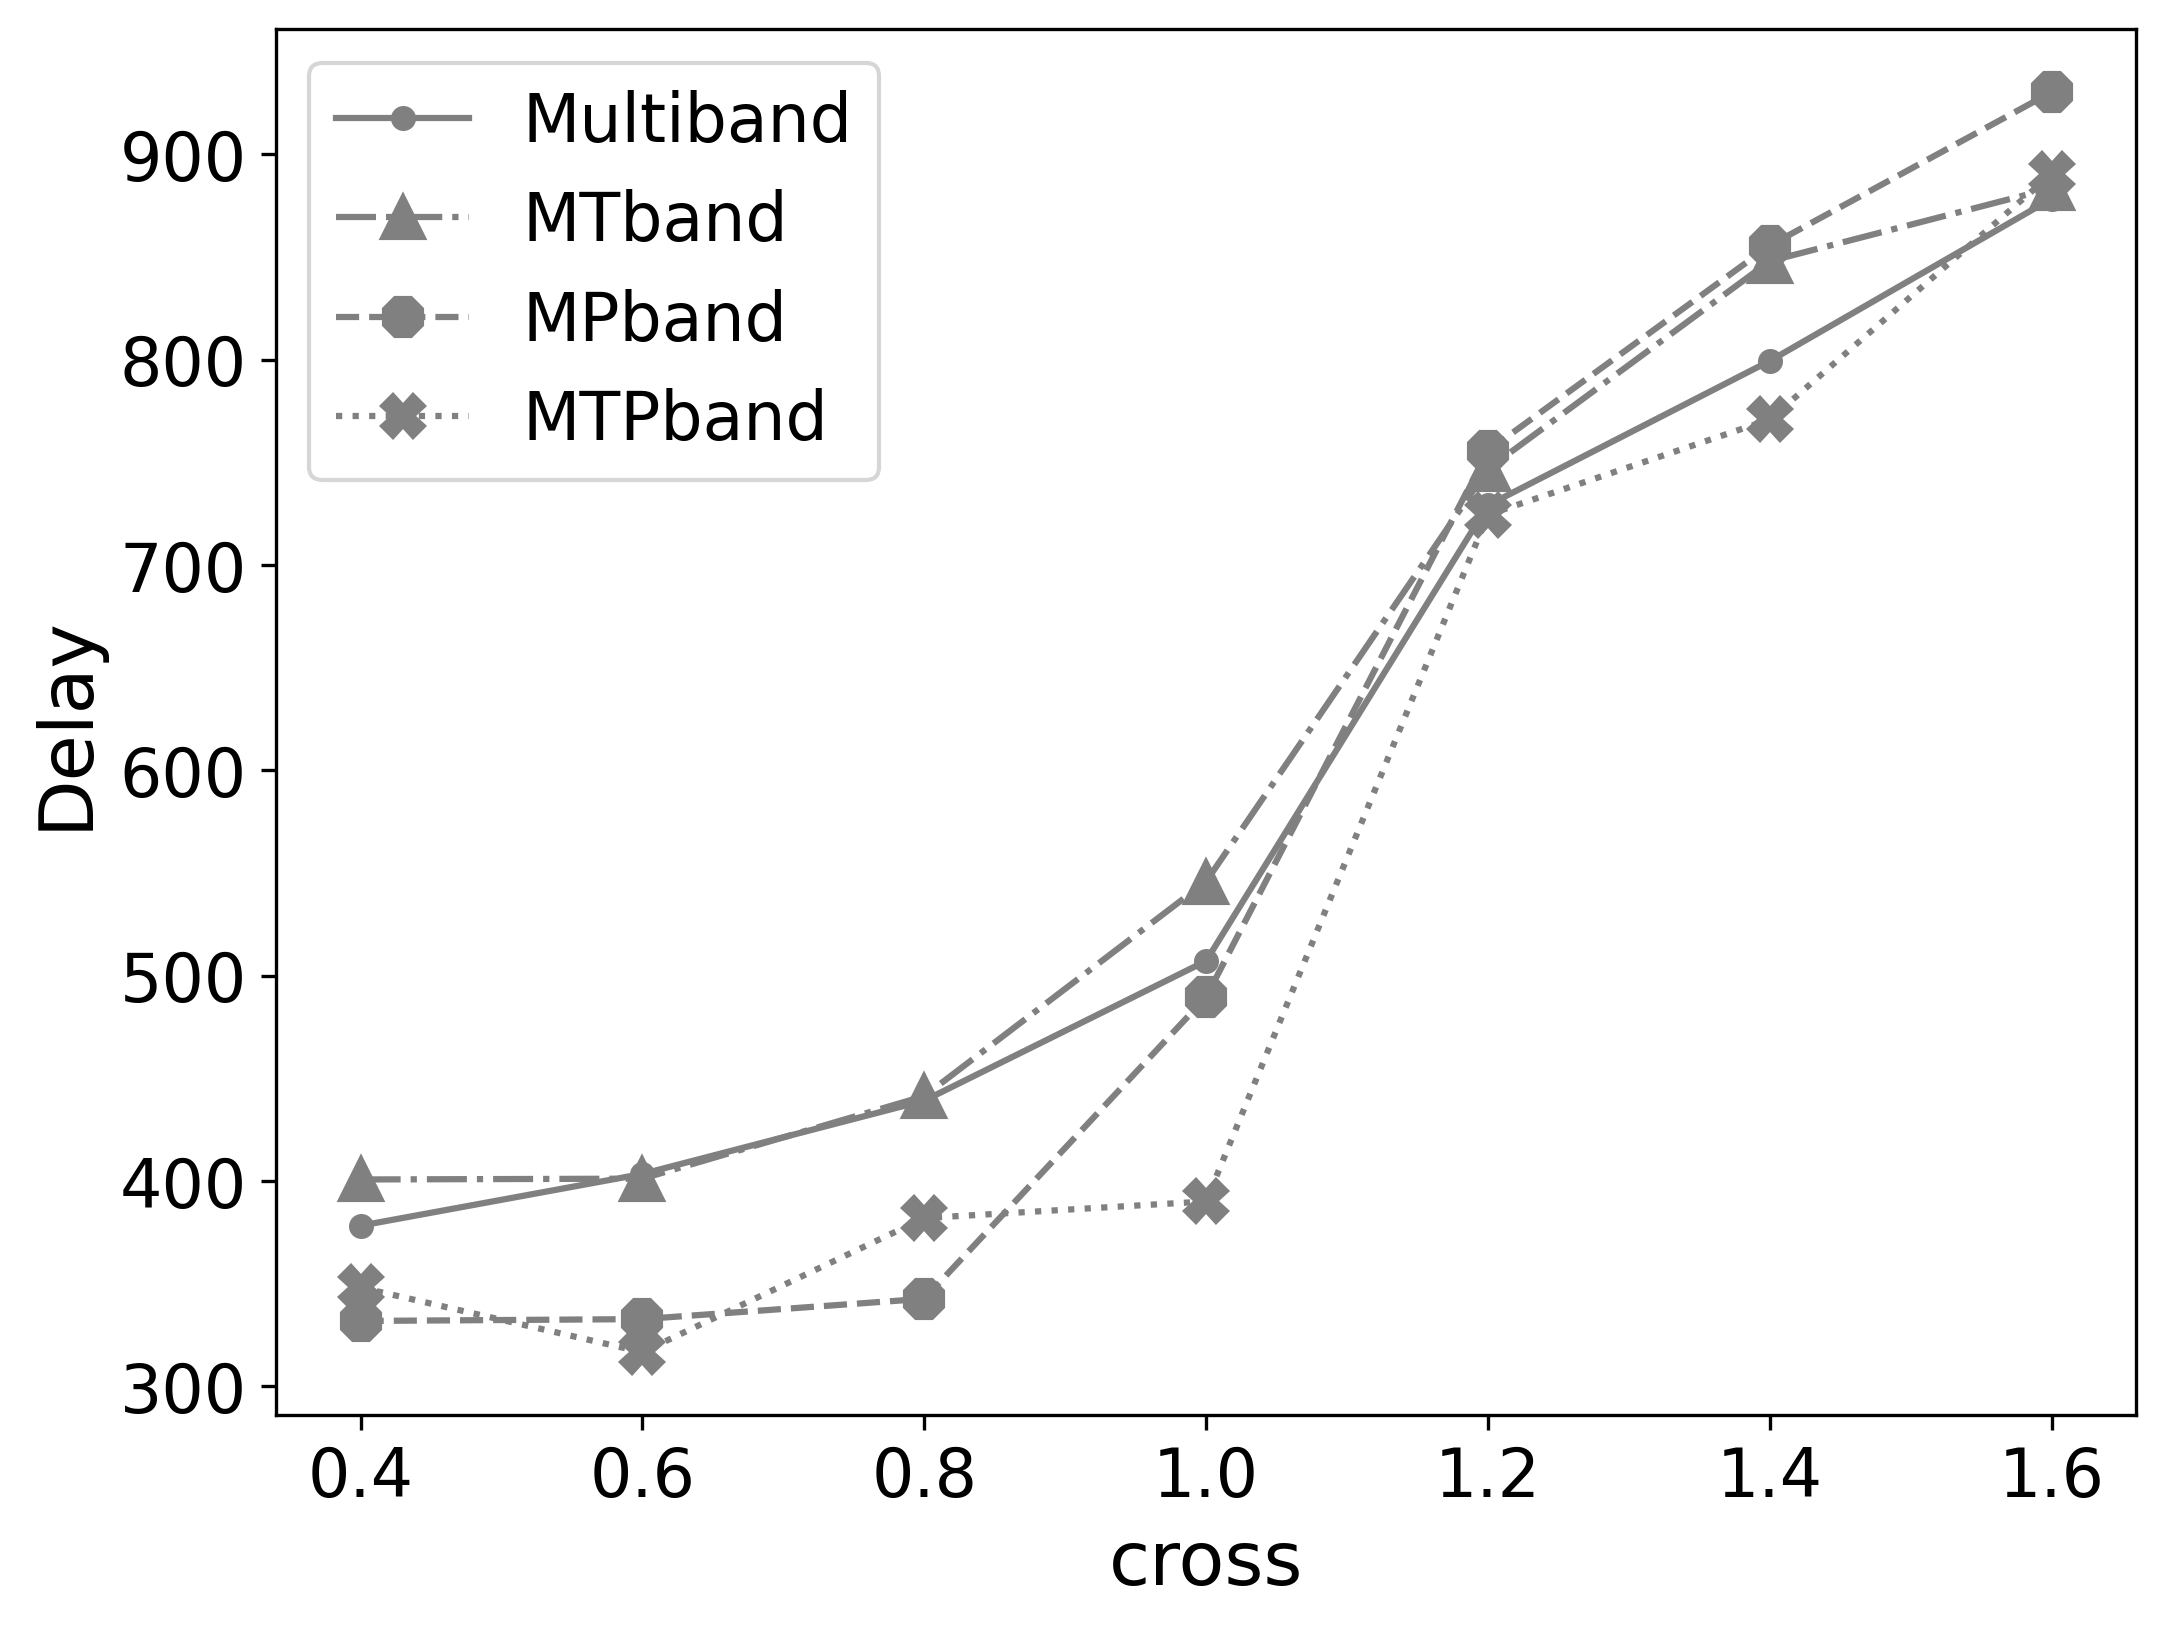

In [24]:
dc=get_delay(sta_list,"sta")
dt=get_traveltime(sta_list,"sta")

fig2 = plt.figure(figsize=[8, 6], dpi=300)
plt.plot(sta_list,dc["MB"][0],label='Multiband',linestyle="-",linewidth=1.5, marker='.',markersize=10,color='Grey',markerfacecolor='Grey')
plt.plot(sta_list,dc["MXB"][0],label='MTband',linestyle="-.",linewidth=1.5, marker='^',markersize=10,color='Grey',markerfacecolor='Grey')
plt.plot(sta_list,dc["MPB"][0],label='MPband',linestyle="--",linewidth=1.5, marker='8',markersize=10,color='Grey',markerfacecolor='Grey')
plt.plot(sta_list,dc["LMB"][0],label='MTPband',linestyle=":",linewidth=1.5, marker='X',markersize=10,color='Grey',markerfacecolor='Grey')
plt.legend(fontsize=16,loc="upper left")
# plt.xticks([i+1 for i in range(13)])
# plt.ylim([50,170])
plt.xlabel('cross', fontsize=18)
plt.ylabel('Delay', fontsize=18)
plt.tick_params(labelsize=16)
# plt.title("延误随饱和度的变化趋势", fontsize=16, y=-.11)
fig2.savefig('./spx15',bbox_inches="tight")